In [23]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [24]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


with sqlite3.connect("games2.sqlite") as con:
    con.row_factory = dict_factory
    query3 = """
        SELECT
            g.result,
            p.eval,
            p.ply,
            g.elo_white - g.elo_black as elo_dif
        FROM
            games g INNER JOIN positions p
            ON g.rowid = p.game_id
        WHERE
            g.result != 2
            AND p.eval is not NULL
        """

    query2 = """
        SELECT 
            g.result,
            MIN(m.eval) as eval_min,
            MAX(m.eval) as eval_max,
            AVG(m.eval) as eval_avg
        FROM 
            games g INNER JOIN moves m 
            ON g.url = m.url
        WHERE
            g.result != 3
            AND m.eval is not NULL
            AND m.eval < 9900
            AND m.eval > -9900
        GROUP BY g.url
        """

    res = con.execute(query2)
    df = pd.DataFrame(res)

con.close()
# df["eval"] = np.log10(df["eval"], where=df["val"])

<AxesSubplot: xlabel='ply', ylabel='eval'>

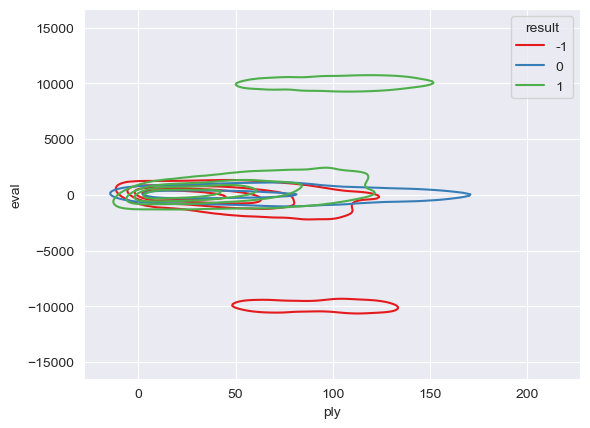

In [25]:
sns.kdeplot(
    df,
    # bins=(50, 50),
    x="ply",
    y="eval",
    hue="result",
    # s=3,
    fill=False,
    palette="Set1",
    levels=5
)
# plt.yscale('symlog')

<AxesSubplot: xlabel='eval', ylabel='result'>

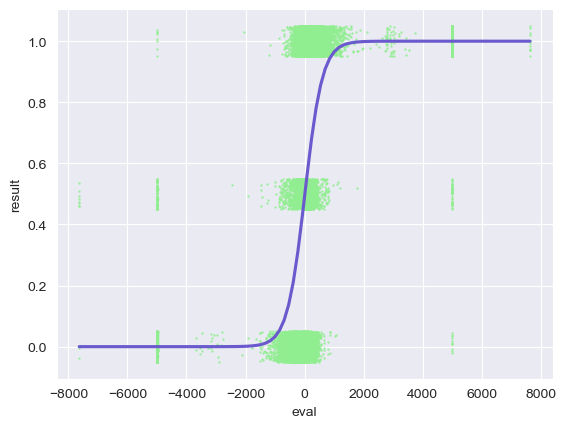

In [26]:
sns.regplot(
    data=(df + 1) / 2,
    x="eval",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [27]:
random_state = 42

features = [
    "eval",
    "ply",
    # "elo_dif"
]
# features = ["eval_min", "eval_max"]
X = df[features]
y = df.result

classifier = LogisticRegressionCV(
    Cs=15,
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=15),
    # class_weight="balanced",
)

scaler = StandardScaler()
model = make_pipeline(scaler, classifier)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, stratify=y
)

model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=15,
                                      l1_ratios=array([0.0, 0.071429, 0.14286, 0.21429, 0.28571, 0.35714, 0.42857, 0.5,
       0.57143, 0.64286, 0.71429, 0.78571, 0.85714, 0.92857, 1.0]),
                                      n_jobs=-1, penalty='elasticnet',
                                      random_state=42, solver='saga'))])

In [28]:
print(f"Accuracy: \n {model.score(X_test, y_test)}")
scale = model.named_steps["standardscaler"].scale_

coefs = model.named_steps["logisticregressioncv"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["logisticregressioncv"].intercept_ / scale.reshape(-1, 1)
print(f"Intercept: \n {intercept}")

cs = model.named_steps["logisticregressioncv"].C_
print(f"Regularization strenght: \n {cs}")


Accuracy: 
 0.5986694453350433
Coefficients: 
 [[-0.00080454 -0.0030509]
 [-0.000164 0.02238]
 [0.0012079 -0.0025397]]
Intercept: 
 [[0.00012487 -0.00032573 0.00020085]
 [0.0087585 -0.022846 0.014088]]
Regularization strenght: 
 [0.019307 0.019307 0.019307]


In [29]:
model.named_steps["logisticregressioncv"].intercept_

array([0.28981, -0.75596, 0.46615])

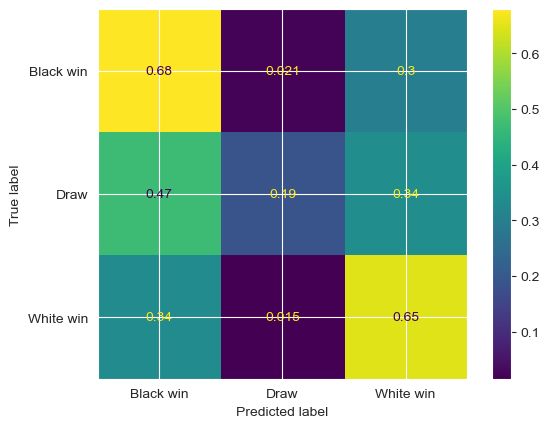

In [38]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    normalize="true",
    display_labels=[
        "Black win",
        "Draw",
        "White win",
    ],
)


In [31]:
test_pawn = np.array([[-1, 2]])
model.predict_proba(test_pawn)

c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.4905, 0.053547, 0.45596]])

In [32]:
# testcase = 1 / (1 + np.exp(-coefs * test_pawn - intercept))
# print(f"Tested coefs: \n {testcase}")

In [33]:
# x: (n_samples, n_features)
# coefs: (n_classes, n_features)
# intercept (n_classes)
# scale: (n_features)
testcase = 1 / (1 + np.exp((coefs * test_pawn).T - intercept))
print(f"Tested coefs: \n {testcase}")

Tested coefs: 
 [[0.49983 0.49988 0.50035]
 [0.50372 0.4831 0.50479]]


In [34]:
test_pawn.shape

(1, 2)

In [35]:
coefs.shape

(3, 2)

In [36]:
coefs[:, None]

array([[[-0.00080454, -0.0030509]],

       [[-0.000164, 0.02238]],

       [[0.0012079, -0.0025397]]])

In [37]:
intercept.shape

(2, 3)